In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
from scipy.stats import zscore
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)

random_state = 1000

In [2]:
df = pd.read_csv('../data/rock_data.csv')

# handle missing values
if df.isnull().values.any():
    df.fillna(df.mean(), inplace=True)
    print('Missing values filled with mean.')
    
# normalize features
df.iloc[:,3:] = df.iloc[:,3:].apply(zscore)

# detect and remove outliers
in_idx = np.ones((len(df),), dtype=bool)

for column in df.columns[3:]:
    n_outliers = sum(abs(zscore(df[column]))>3) 
    in_idx[abs(zscore(df[column]))>3] = False
    
    if n_outliers > 0:
        print(f'Remove {n_outliers} outliers of {column}')
        
df = df.loc[in_idx]

Remove 13 outliers of Perimeter
Remove 12 outliers of Area
Remove 13 outliers of Axis Major Length
Remove 4 outliers of Axis Minor Length
Remove 7 outliers of Mean Height
Remove 9 outliers of Median Height
Remove 5 outliers of Max Height
Remove 5 outliers of STD Height
Remove 14 outliers of Mean Gradient
Remove 13 outliers of STD Gradient
Remove 23 outliers of Gradient at Max
Remove 11 outliers of Weighted Hu Moment 1
Remove 26 outliers of Weighted Hu Moment 2
Remove 18 outliers of Weighted Hu Moment 3
Remove 12 outliers of Weighted Hu Moment 4


In [3]:
X = df.iloc[:,3:].to_numpy(dtype=float)

def map_class_values(x):
    mapping = {12: 0, 58: 1, 34: 2}
    return mapping.get(x,None)

y = np.vectorize(map_class_values)(df['Class'].values)

In [4]:
# training:validation:testing = 60:20:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=random_state)

In [5]:
model_names = ['KNN', 'SVC', 'RF', 'XGB', 'MLP']
models = [KNeighborsClassifier(), SVC(), RandomForestClassifier(), XGBClassifier(), MLPClassifier(max_iter=500)]
grid_params = [{'n_neighbors': [5, 10, 15, 20], 'weights': ['uniform', 'distance']}, {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}, {'n_estimators': [10, 100, 200], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_features': ['sqrt', 'log2', None]}, {'max_depth': [3,5,7], 'n_estimators': [10, 100, 200], 'reg_lambda': [1e-3, 1, 1e3]}, {'hidden_layer_sizes': [(100,), (100,50), (100,50,100)], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'alpha': [1e-3, 1, 1e3]}]

KNN with {'n_neighbors': 15, 'weights': 'uniform'} 
               precision    recall  f1-score   support

           0       0.65      0.87      0.75        69
           1       0.57      0.41      0.48        56
           2       0.77      0.70      0.73        73

    accuracy                           0.68       198
   macro avg       0.67      0.66      0.65       198
weighted avg       0.67      0.68      0.67       198




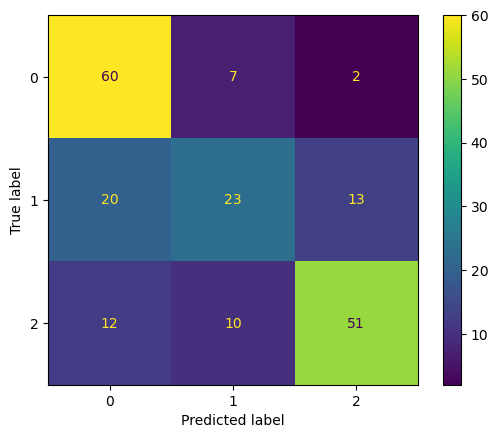

SVC with {'C': 1, 'kernel': 'linear'} 
               precision    recall  f1-score   support

           0       0.71      0.84      0.77        69
           1       0.51      0.43      0.47        56
           2       0.74      0.70      0.72        73

    accuracy                           0.67       198
   macro avg       0.65      0.66      0.65       198
weighted avg       0.66      0.67      0.66       198




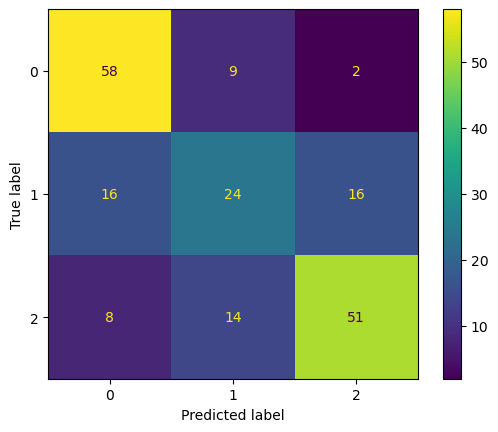

RF with {'criterion': 'log_loss', 'max_features': None, 'n_estimators': 100} 
               precision    recall  f1-score   support

           0       0.75      0.86      0.80        69
           1       0.56      0.59      0.57        56
           2       0.78      0.64      0.71        73

    accuracy                           0.70       198
   macro avg       0.70      0.70      0.69       198
weighted avg       0.71      0.70      0.70       198




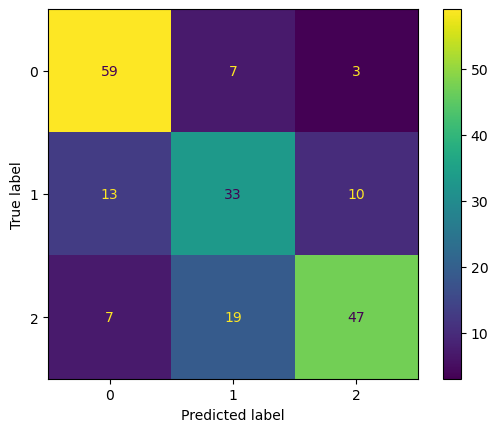

XGB with {'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0.001} 
               precision    recall  f1-score   support

           0       0.72      0.84      0.78        69
           1       0.51      0.45      0.48        56
           2       0.71      0.67      0.69        73

    accuracy                           0.67       198
   macro avg       0.65      0.65      0.65       198
weighted avg       0.66      0.67      0.66       198




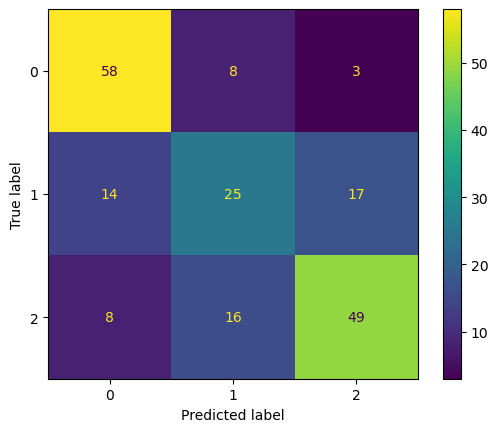

MLP with {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (100, 50)} 
               precision    recall  f1-score   support

           0       0.74      0.86      0.79        69
           1       0.47      0.41      0.44        56
           2       0.72      0.68      0.70        73

    accuracy                           0.67       198
   macro avg       0.64      0.65      0.64       198
weighted avg       0.66      0.67      0.66       198




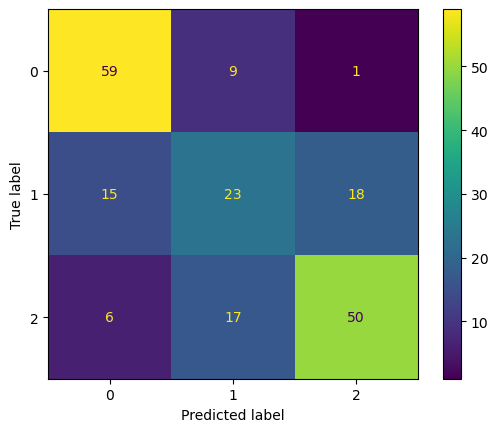

In [6]:
for m,model in enumerate(models):
    grid_search = GridSearchCV(model, grid_params[m], cv=5)
    grid_search.fit(X_train, y_train)
    model_best = grid_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    print(f'{model_names[m]} with {grid_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()

In [7]:
search_spaces = [{
    'n_neighbors': Integer(3,50),
    'weights': Categorical(['uniform', 'distance'])
    },
    
    {
    'C': Real(0.1, 10, 'log-uniform'),
    'kernel': Categorical(['linear', 'rbf', 'sigmoid']),
    },
    
    {
    'n_estimators': Integer(10,200),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_features': Categorical(['sqrt', 'log2', None]),
    },
    
    {
    'max_depth': Integer(3,10),
    'n_estimators': Integer(10,200),
    'reg_lambda': Real(1e-3, 1e3, 'log-uniform'),
    }
    ]

KNN with OrderedDict([('n_neighbors', 21), ('weights', 'distance')]) 
               precision    recall  f1-score   support

           0       0.67      0.84      0.75        69
           1       0.57      0.43      0.49        56
           2       0.74      0.71      0.73        73

    accuracy                           0.68       198
   macro avg       0.66      0.66      0.66       198
weighted avg       0.67      0.68      0.67       198




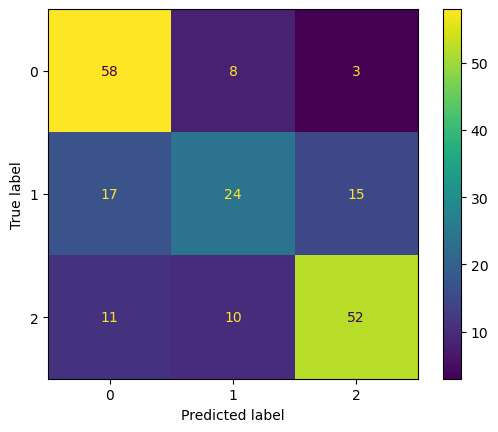

SVC with OrderedDict([('C', 4.164820160895745), ('kernel', 'linear')]) 
               precision    recall  f1-score   support

           0       0.72      0.84      0.77        69
           1       0.51      0.48      0.50        56
           2       0.75      0.66      0.70        73

    accuracy                           0.67       198
   macro avg       0.66      0.66      0.66       198
weighted avg       0.67      0.67      0.67       198




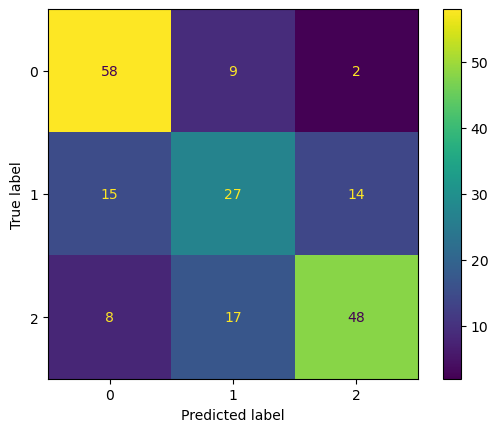

RF with OrderedDict([('criterion', 'log_loss'), ('max_features', None), ('n_estimators', 200)]) 
               precision    recall  f1-score   support

           0       0.73      0.84      0.78        69
           1       0.58      0.57      0.58        56
           2       0.77      0.67      0.72        73

    accuracy                           0.70       198
   macro avg       0.69      0.69      0.69       198
weighted avg       0.70      0.70      0.70       198




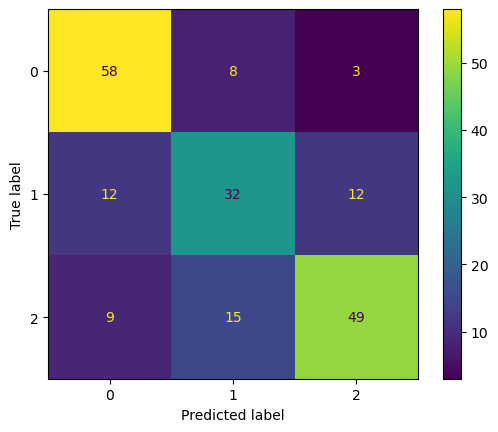

XGB with OrderedDict([('max_depth', 9), ('n_estimators', 194), ('reg_lambda', 0.008829020245085783)]) 
               precision    recall  f1-score   support

           0       0.72      0.84      0.78        69
           1       0.56      0.48      0.52        56
           2       0.71      0.68      0.70        73

    accuracy                           0.68       198
   macro avg       0.67      0.67      0.67       198
weighted avg       0.68      0.68      0.68       198




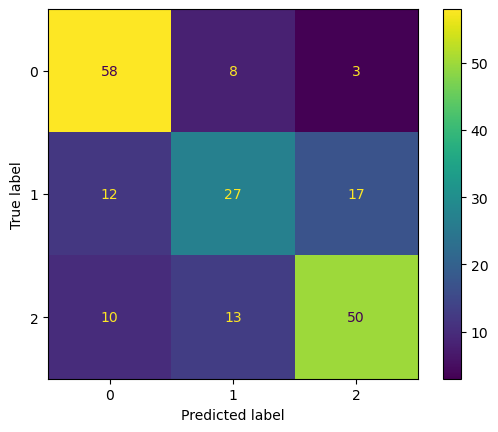

In [8]:
for m,model in enumerate(models[:-1]):
    bayes_search = BayesSearchCV(model, search_spaces[m], n_iter=50, cv=5, n_jobs=-1)
    bayes_search.fit(X_train, y_train)
    model_best = bayes_search.best_estimator_
    model_best_pred = model_best.predict(X_val)
    print(f'{model_names[m]} with {bayes_search.best_params_} \n {classification_report(y_val, model_best_pred)}\n')
    ConfusionMatrixDisplay(confusion_matrix(y_val, model_best_pred)).plot()
    show()